In [1]:
import numpy as np
import torch
import re
import jieba
import newspaper
import pandas as pd
from tqdm import tqdm
import os.path
from os import listdir
import torch
from itertools import permutations
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
from IPython.display import Image,display,display_html,display_markdown

In [2]:
def find_file(key_word,dir = os.getcwd()):
    file_paths = [os.path.join(dir, f) for f in listdir(dir) if os.path.isfile(os.path.join(dir, f)) and key_word in os.path.join(dir, f)][0]
    return file_paths

# 加载文本
corpus = find_file("南方网 3.csv")
stop_word_path = find_file("chinese_symbols.txt","{}{}".format(os.getcwd().replace('NLP',""),'NLP数据集合/停词库/'))

#临时删除文本元素
def del_element(strings,symbles,Replace_the_symbol=" @REPLACETHESYMBOL@ "):
    srcrep = {i:Replace_the_symbol for i in symbles }
    rep = dict((re.escape(k), v) for k, v in srcrep.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], strings)

def replace_number(strings,NUMBERTOKEN = ' @NUMBERTOKEN@ '):
    return re.sub(r'\d+',NUMBERTOKEN,strings)

#加载停用词
stop_words = stop_words = ''.join(open(stop_word_path,'r').read().split('\n')+['\n'])

#过滤停用词
def filter_stop_word(paper,stop_words):
    return np.array(list(filter(lambda x: x not in stop_words,jieba.cut(del_element(paper,'\n')))))

#读取本地新闻
def read_txt(corpus):
    return np.array([re.sub('\n','',str(word)) for word in tqdm(pd.read_csv(corpus).text,desc='加载文章')])

#只要中文
def just_chinese(strings):
    regStr = ".*?([\u4E00-\u9FA5]+).*?"
    expr = ''.join(re.findall(regStr, strings))
    if expr:
        return expr
    return '\n'

#分词删除
def split_word(original,temp_del=stop_words,just_chinese=False):
    result = []
    for paper in tqdm(original,desc='分词文章'):
        if just_chinese:
            paper_ = just_chinese(paper)
        paper_1 = del_element(paper,stop_words)
        paper_ = replace_number(paper_1)
        temp_split_words = filter_stop_word(paper_,stop_words)
        result.append(temp_split_words)
    return np.array(result)

# 排序字典
def sort_dict(dict_items):
    sorted_tuple = np.array(sorted(dict_items.items(), key=lambda x: x[0], reverse=True))
    return dict(zip(sorted_tuple[:,0],sorted_tuple[:,1]))

# 单词编码器
def word_encoding(all_words):
    unique,index_,counter= np.unique(all_words,return_counts=True,return_index=True)
    encode_dict = dict(zip(unique,index_))
    decode_dict = dict(zip(index_,unique))
    prob_of_word_dict = dict(zip(unique,counter/unique.size))
    prob_of_word_dict_to_log = dict(zip(unique,-np.log(counter/all_words.size)))
    return decode_dict,encode_dict,prob_of_word_dict,prob_of_word_dict_to_log

# 编码向量
def encode_papers(split_paper,encode_dict):
    # 所有单词降维到一维
    return [torch.tensor([encode_dict[word] for word in paper]) for paper in tqdm(split_paper,desc='词列表转<tensor>编码')]

def to_numpy(data):
    if isinstance(data,np.ndarray):
        return data
    else:
        return np.array(data)

def INIT_Ngram(word_list,n):
    m = word_list.size
    end = np.array([np.array([word_list[j] for j in range(i) ][-n:]) for i in tqdm(range(m+1),desc='Ngram初始化')][1:])
    return list(zip(word_list,end))

'''数据预处理函数'''
def data_preprocessing_to_tensor(corpus,stop_words=stop_words,just_chinese=False):
    # 读取原文
    read_original = read_txt(corpus) 
    # 倒入文章并分词
    split_paper = split_word(read_original,stop_words,just_chinese=just_chinese)
    # 所有单词降维到一维
    all_words = np.array([j for i in tqdm(split_paper,desc='词列表降维') for j in i])
    # 所有文章合并到一行并且补足符号
    one_row = [word for paper in tqdm(split_paper,desc="文章列表降维补码") for word in np.append(paper,'NEWLINE')]+['NEWLINE']
    one_row.insert(0,'NEWLINE')
    papers_to_one_dim = np.array(one_row)
    # 单词编码
    decode_dict,encode_dict,prob_of_word_dict,prob_of_word_dict_to_log = word_encoding(all_words)
    # 转tensor
    code_paper = encode_papers(split_paper,encode_dict)
    # 编码向量
    code_tensor = torch.unique(torch.tensor(list(decode_dict)))


    return decode_dict,encode_dict,prob_of_word_dict,prob_of_word_dict_to_log,all_words,papers_to_one_dim,read_original,split_paper,code_tensor,code_paper


'''TF-IDF torch'''
def TF_Tensor(tensor_paper,code_tensor):
    unique,counts = torch.unique(tensor_paper,return_counts=True)
    init_TF = torch.zeros(code_tensor.size())
    for e,c in zip(unique,counts):
        if e in code_tensor:
            index_ = np.where(code_tensor == e)[0][0]
            init_TF[index_] = c
    return init_TF

def IDF_Tensor(tensor_papers,code_tensor):
    N = len(tensor_papers)
    NW = torch.zeros(code_tensor.size())
    step = -1
    for word_code in tqdm(code_tensor,desc="IDF词汇"):
        step += 1
        counter = sum((word_code in paper_code for paper_code in tensor_papers))
        NW[step] = counter
    return torch.log(N/(NW+1))

def TFIDFTensor(tensor_papers,code_tensor):
    IDF = IDF_Tensor(tensor_papers,code_tensor)
    m = len(tensor_papers)
    n = int(code_tensor.size()[0])
    DF = torch.zeros(m,n)
    step = -1
    for paper in tqdm(tensor_papers,desc="TF矩阵"):
        step += 1
        DF[step] = TF_Tensor(paper,code_tensor)
    return DF*IDF

#静态配置
decode_dict,encode_dict,prob_of_word_dict,prob_of_word_dict_to_log,all_words,papers_to_one_dim,read_original,split_paper,code_tensor,code_paper = data_preprocessing_to_tensor(corpus)

# 初始化Ngram (耗时极长，且需要大量内存)
#init_Ngram = INIT_Ngram(papers_to_one_dim,2)
# torch训练TFIDF
#TFIDF = TFIDFTensor(code_paper,code_tensor)

分词文章:   0%|          | 0/1217 [00:00<?, ?it/s]Building prefix dict from /usr/local/lib/python3.7/site-packages/jieba/dict.txt ...
Dumping model to file cache /var/folders/sl/q8x6_03132dfk7rktf00yh880000gn/T/jieba.cache
Loading model cost 1.48067307472229 seconds.
Prefix dict has been built succesfully.
词列表转<tensor>编码: 100%|██████████| 1217/1217 [00:00<00:00, 1307.63it/s]


prob_of_word_dict

# 分词及前后向查找组件

In [3]:
def token(paper):
    return np.array(list(jieba.cut(paper)))

def Ngram(word_list,n):
    sentence = to_numpy(word_list)
    m = sentence.size
    end = np.array([np.array([word_list[j] for j in range(i) ][-n:]) for i in range(m+1)][1:])
    return end

def forward_check(word,n=2,word_docker=split_paper):
    start = -1
    result = []
    if word in stop_words:
        word = "REPLACETHESYMBOL"
    for paper in word_docker:
        start += 1
        if word in paper:
            ends = np.ravel(np.argwhere(paper==word))
            for end in ends:
                end_first = end-(n-1)
                if end_first:
                    result.append(word_docker[start][end_first:end+1])
                else:
                    result.append(word_docker[start][0:end+1])
    return np.array(list(filter(lambda x : len(x) != 0 ,result)))

def backward_check(word,n=2,word_docker=split_paper):
    if word in list(stop_words):
        word = "REPLACETHESYMBOL"
    start = -1
    result = []
    for paper in word_docker:
        start += 1
        if word in paper:
            ends = np.ravel(np.argwhere(paper==word))
            for end in ends:
                if end+n < paper.size:
                    result.append(word_docker[start][end:end+n])
                else:
                    start_arr = word_docker[start][end:end+1]
                    end_arr = [word]*(n-1)
                    result.append(np.append(start_arr,end_arr))
    return np.array(list(filter(lambda x : len(x) != 0 ,result)))


In [4]:
V = papers_to_one_dim[papers_to_one_dim!='NEWLINE'].size

In [5]:
def to_dictionary(word,word_dict=prob_of_word_dict):
    try:
        return word_dict[word]
    except Exception:
        return 0

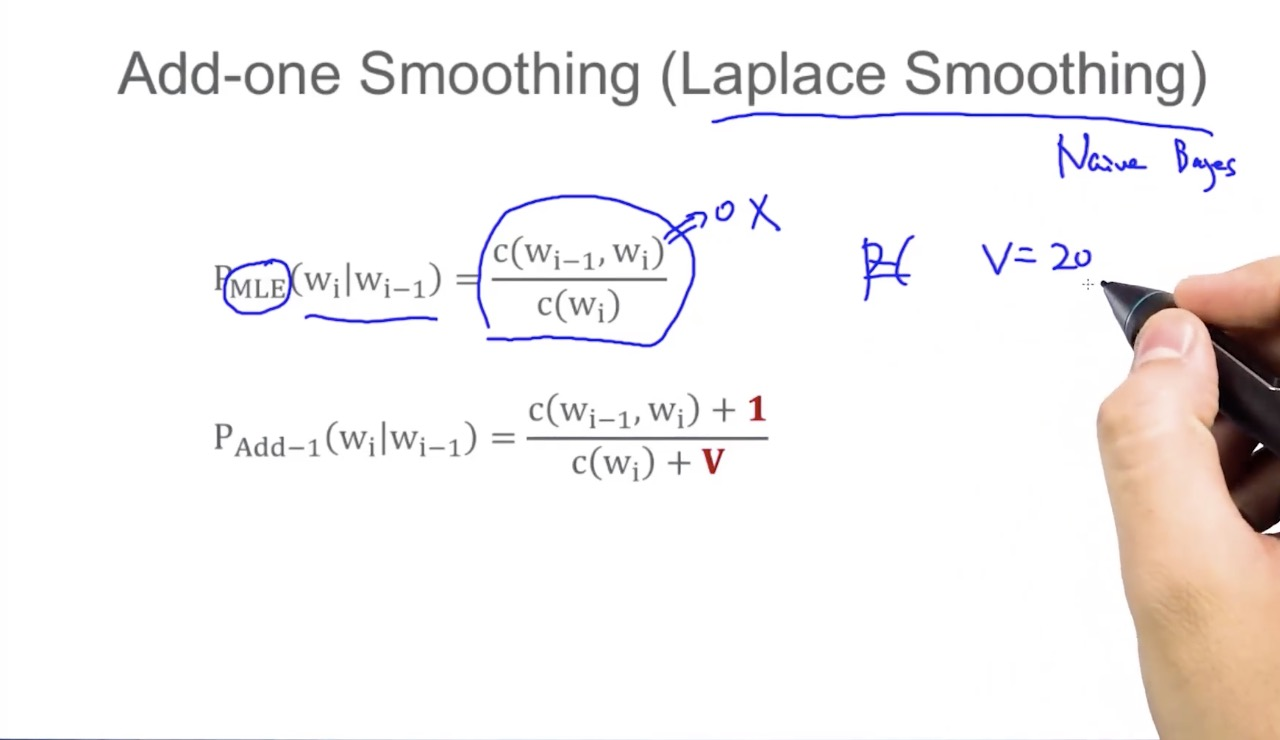

In [6]:
display(Image("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP/图片/BEB069CB-276B-44BF-88AE-1AA9B8AD2FCE.png"))

# V = 出现的单词量
# Wi = 边缘概率
# Wireaduce1 = 联合概率
# 可以用在朴素贝叶斯，也叫拉普拉斯smoothing

## 查字典

In [7]:
def Add_one_Smoothing(Wi,Wireduce1,V=None,word_dict=prob_of_word_dict):
    return (Wireduce1+1)/(Wi+V)

In [8]:
Add_one_Smoothing(0,0,100)

0.01

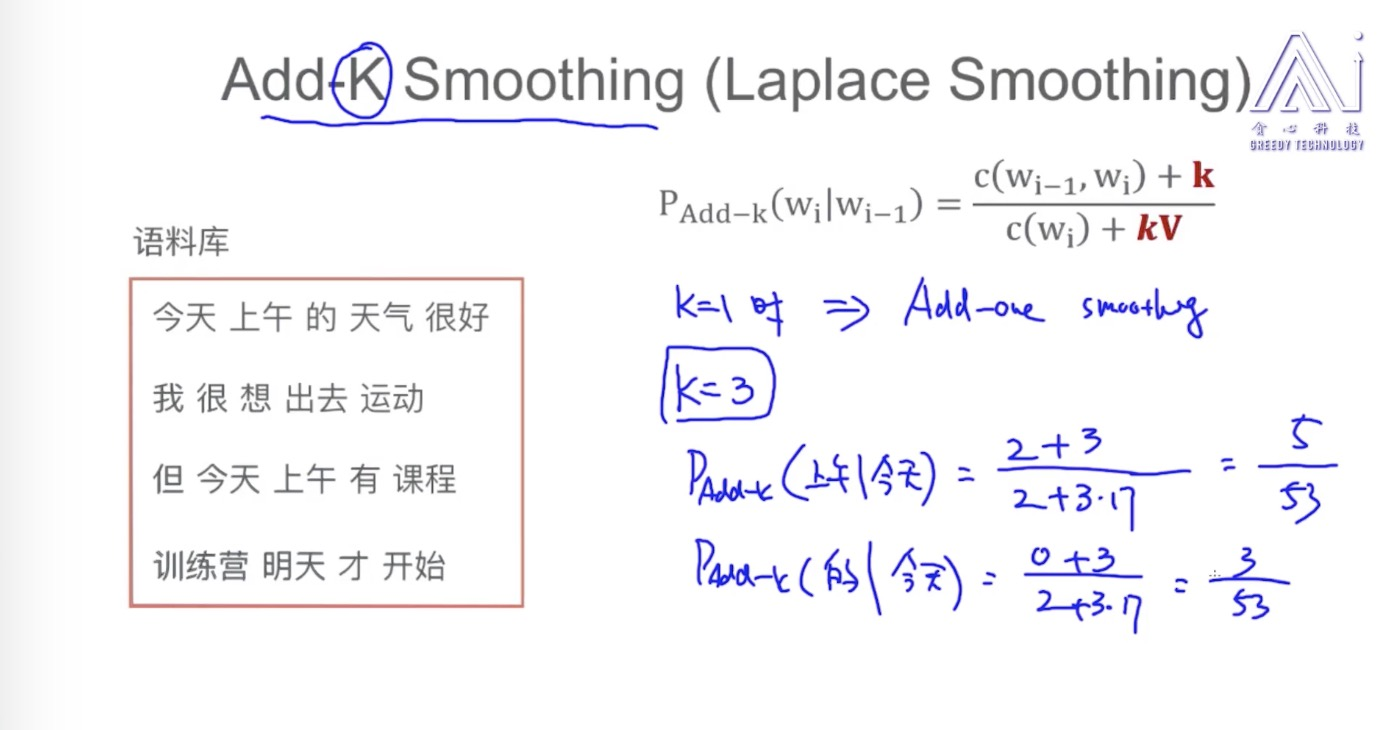

In [9]:
display(Image("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP/图片/1CF5E65C-7355-49A1-935E-261E3BBAF04D.png"))

In [10]:
def Add_K_Smoothing(Wi,Wireduce1,k,V,word_dict=prob_of_word_dict):
    return (Wireduce1+k)/(Wi+k*V)


In [11]:
Add_K_Smoothing(0,0,1,100)

0.01

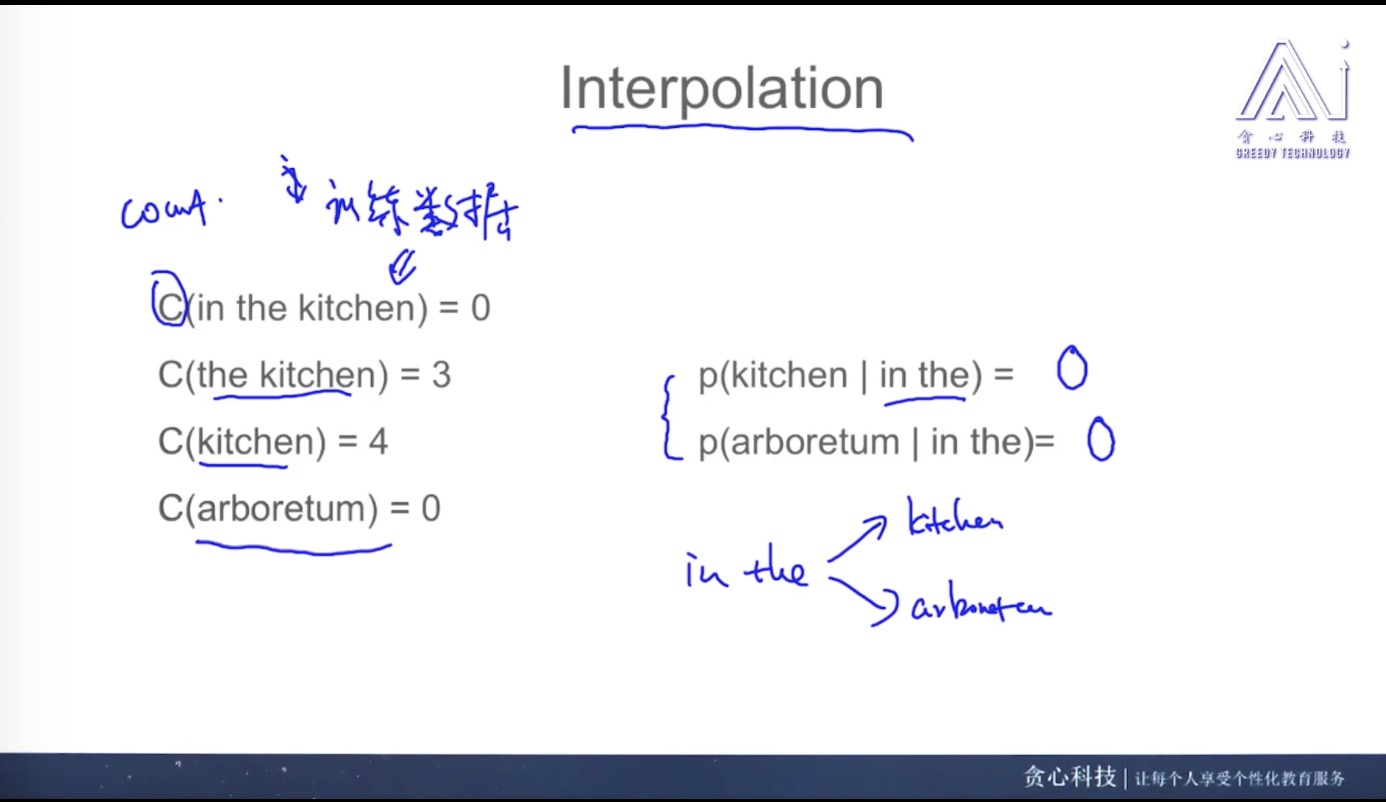

In [12]:
display(Image("/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/NLP/图片/7331A0A6-0DCF-4EBE-AEF9-6D4C8F0478B4.png"))

# 当原本词汇量不足时，用降低要求的标准去替换缺失的概率

# interpolation 本质上是加权平均

In [13]:
def interpolation(raw_text):
    raw_text = to_numpy(raw_text)
    n = raw_text.size
    end = raw_text[-1]
    prob = [1/n+to_dictionary(end)]
    for i in range(2,raw_text.size+1):
        find = forward_check(end,i)
        if len(find) == 0:
            return 10**(-8)
        w = raw_text[n-i:]
        check = (find==w).sum(axis=1)==i
        counter = check.sum()
        prob.append(1/n+counter/check.size)
    return np.mean(prob)

interpolation(['美国', '总统', '特朗普'])

0.6190880847500458

# 平滑优化器组建

In [14]:
def prob_optimize(raw_text,k=2,optimize='min'):
    raw_text = to_numpy(raw_text)
    n = raw_text.size
    AB = raw_text
    B = raw_text[-1]
    search_backward = backward_check(B,n,split_paper)
    if len(search_backward)==0:
        print('mini')
        return 10**(-8)
    check_backward = search_backward==AB
    backward_bool = check_backward.all(axis=1)
    counter = backward_bool.sum()
    print(AB,B)
    PAB = counter/backward_bool.size
    PB = to_dictionary(B)
    V = papers_to_one_dim[papers_to_one_dim!='NEWLINE'].size
    if optimize == 'min' :
        print('min')
        if PAB*PB == 0:
            return 10**(-8)
    elif optimize == 'add one smoothing':
        print('add one smoothing')
        return Add_one_Smoothing(PB,PAB,V)
    elif optimize == 'add k smoothing':
        print('add k smoothing')
        return Add_K_Smoothing(PB,PAB,k,V)
    elif optimize == 'interpolation':
        print('interpolation')
        return interpolation(raw_text)
    else:
        return PAB/PB


prob_optimize(['美国', '总统', '特朗普'],k=79,optimize='add one smoothing')

['美国' '总统' '特朗普'] 特朗普
add one smoothing


8.914403892846918e-07

In [19]:
def get_prob(iterable,n,k=2,optimize='min'):
    start = iterable[0]
    m = len(iterable)
    if n == 1:
        return to_dictionary(start)
    else:
        if n > m:
            n = m-1
        return prob_optimize(iterable,k,optimize=optimize)

def LanguageModel(raw_text,n=2,k=2,word_docker=split_paper,word_dict=prob_of_word_dict,V = papers_to_one_dim[papers_to_one_dim!='NEWLINE'].size,optimize_key ='add k smoothing'):
    expr , text , prob_list = 0 ,[] ,[]
    for gram in Ngram(raw_text,n):
        prob = get_prob(gram,gram.size,k,optimize_key)
        expr += prob!=10**(-8) and -np.log(prob) or 10**(-8)
        prob_list.append((gram,prob,-np.log(prob)))
        text.append(gram[-1])
    return {expr:text},prob_list
   
raw_text = token('莫非前世的约定，今生的宿命')

LanguageModel(raw_text,n=2,optimize_key='interpolation')

['莫非' '前世'] 前世
interpolation
['前世' '的'] 的
interpolation
['的' '约定'] 约定
interpolation
['约定' '，'] ，
interpolation
['，' '今生'] 今生
interpolation
['今生' '的'] 的
interpolation
mini


({13.914352911754131: ['莫非', '前世', '的', '约定', '，', '今生', '的', '宿命']},
 [(array(['莫非'], dtype='<U2'), 1.7342443897193994e-05, 10.962353656681723),
  (array(['莫非', '前世'], dtype='<U2'), 0.5000260136658459, 0.6930951545816283),
  (array(['前世', '的'], dtype='<U2'), 0.8875255801047484, 0.11931793539469329),
  (array(['的', '约定'], dtype='<U2'), 0.5304335610974299, 0.634060567041698),
  (array(['约定', '，'], dtype='<U2'), 0.5, 0.6931471805599453),
  (array(['，', '今生'], dtype='<U2'), 0.500043356109743, 0.6930604720997464),
  (array(['今生', '的'], dtype='<U2'), 0.8875255801047484, 0.11931793539469329),
  (array(['的', '宿命'], dtype='<U2'), 1e-08, 18.420680743952367)])

In [16]:
def GoodTurningSmoothing():
    pass

In [1]:
import numpy as np

In [ ]:
np.unique(np.arange(1000),return_counts=)